Dataset chargé: (581012, 55)
Features après regroupement : 12
Train/Test: (464809, 12) (116203, 12)
Accuracy: 0.8322  |  F1-weighted: 0.8312
              precision    recall  f1-score   support

           1       0.83      0.84      0.83     42368
           2       0.86      0.86      0.86     56661
           3       0.82      0.76      0.79      7151
           4       0.75      0.64      0.69       549
           5       0.76      0.38      0.51      1899
           6       0.58      0.68      0.63      3473
           7       0.86      0.81      0.83      4102

    accuracy                           0.83    116203
   macro avg       0.78      0.71      0.73    116203
weighted avg       0.83      0.83      0.83    116203



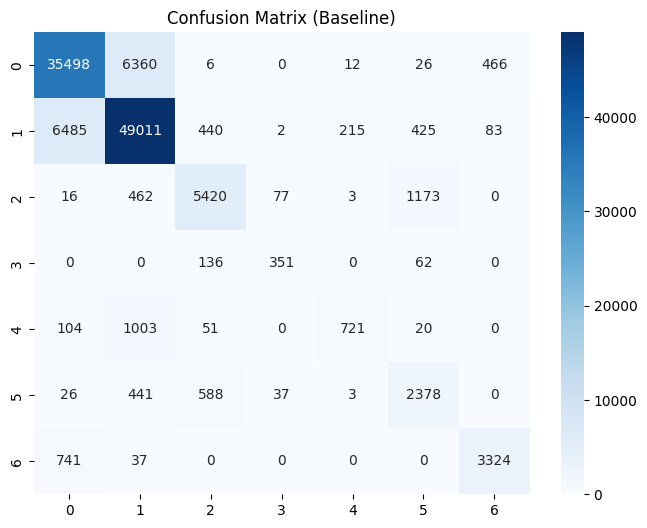

Confusion matrix sauvegardée: results_mlp\confusion_matrix_mlp.png


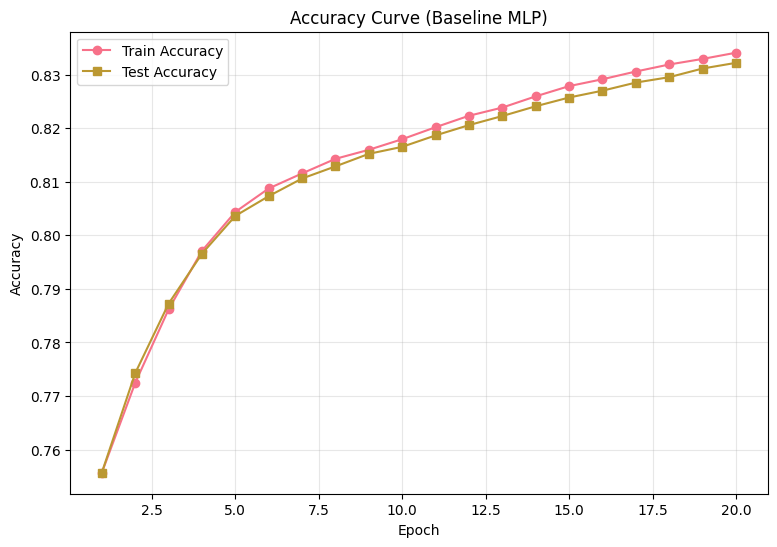

Courbe d'accuracy sauvegardée: results_mlp\accuracy_mlp.png
Rapport sauvegardé: results_mlp\classification_report_mlp.txt
Modèle sauvegardé: results_mlp\mlp_baseline.pkl
Scaler sauvegardé: results_mlp\scaler_mlp_baseline.pkl


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib

plt.style.use("default")
sns.set_palette("husl")

RESULTS_DIR = "results_mlp"
GRAPHS_DIR = os.path.join(RESULTS_DIR, "graphs")
os.makedirs(GRAPHS_DIR, exist_ok=True)

# 1) Load dataset
def load_dataset(path="data/covtype.csv"):
    df = pd.read_csv(path)
    print(f"Dataset chargé: {df.shape}")
    return df

# 2) Preprocess
def preprocess(df):
    df = df.copy()

    # ---------
    # 1) Regrouper Soil_Type (40 → 1)
    # ---------
    soil_cols = [c for c in df.columns if c.startswith("Soil_Type")]
    df["Soil_Type"] = (
        df[soil_cols]
        .idxmax(axis=1)
        .str.replace("Soil_Type", "", regex=False)
        .astype(int)
    )
    df.drop(columns=soil_cols, inplace=True)

    # ---------
    # 2) Regrouper Wilderness_Area (4 → 1)
    # ---------
    wild_cols = [c for c in df.columns if c.startswith("Wilderness_Area")]
    df["Wilderness_Area"] = (
        df[wild_cols]
        .idxmax(axis=1)
        .str.replace("Wilderness_Area", "", regex=False)
        .astype(int)
    )
    df.drop(columns=wild_cols, inplace=True)

    # ---------
    # 3) Séparer X / y
    # ---------
    X = df.drop(columns=["Cover_Type"])
    y = df["Cover_Type"]

    # ---------
    # 4) Normalisation
    # ---------
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Features après regroupement : {X.shape[1]}")

    return X_scaled, y.values, scaler

# 3) Train/Test split
def prepare_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y)
    print("Train/Test:", X_train.shape, X_test.shape)
    return X_train, X_test, y_train, y_test

# 4) Train baseline MLP with accuracy curve
def train_baseline_with_curve(X_train, y_train, X_test, y_test, n_epochs=20):
    classes = np.unique(y_train)
    model = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=0.01,
        max_iter=1,            # one iter per partial_fit step
        warm_start=True,       # allow successive fitting
        random_state=42,
        verbose=False
    )
    train_acc_history = []
    test_acc_history = []

    # First call to partial_fit must include classes
    model.partial_fit(X_train, y_train, classes=classes)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    for _ in range(n_epochs - 1):
        model.partial_fit(X_train, y_train)
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

    return model, train_acc_history, test_acc_history

# 5) Evaluate
def evaluate(model, X_train, X_test, y_train, y_test, train_acc_history=None, test_acc_history=None):
    # Prediction
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Accuracy: {acc:.4f}  |  F1-weighted: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix (Baseline)")
    cm_path = os.path.join(RESULTS_DIR, "confusion_matrix_mlp.png")
    plt.savefig(cm_path, dpi=300)
    plt.show()
    print(f"Confusion matrix sauvegardée: {cm_path}")

    # Accuracy curve if provided
    if train_acc_history is not None and test_acc_history is not None:
        epochs = np.arange(1, len(train_acc_history) + 1)
        plt.figure(figsize=(9,6))
        plt.plot(epochs, train_acc_history, label="Train Accuracy", marker="o")
        plt.plot(epochs, test_acc_history, label="Test Accuracy", marker="s")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curve (Baseline MLP)")
        plt.legend()
        acc_graph_path = os.path.join(RESULTS_DIR, "accuracy_mlp.png")
        plt.grid(True, alpha=0.3)
        plt.savefig(acc_graph_path, dpi=300)
        plt.show()
        print(f"Courbe d'accuracy sauvegardée: {acc_graph_path}")

    report_path = os.path.join(RESULTS_DIR, "classification_report_mlp.txt")
    with open(report_path, "w") as f:
        f.write(classification_report(y_test, y_pred))
    print(f"Rapport sauvegardé: {report_path}")

# 6) Save model
def save_model(model, scaler):
    model_path = os.path.join(RESULTS_DIR, "mlp_baseline.pkl")
    scaler_path = os.path.join(RESULTS_DIR, "scaler_mlp_baseline.pkl")
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    print(f"Modèle sauvegardé: {model_path}")
    print(f"Scaler sauvegardé: {scaler_path}")

# 7) Main
if __name__ == "__main__":
    df = load_dataset()
    X, y, scaler = preprocess(df)
    X_train, X_test, y_train, y_test = prepare_data(X, y)

    model, train_hist, test_hist = train_baseline_with_curve(X_train, y_train, X_test, y_test, n_epochs=20)
    evaluate(model, X_train, X_test, y_train, y_test, train_acc_history=train_hist, test_acc_history=test_hist)
    save_model(model, scaler)
